# Hw 2: Adrian Ramirez

In [363]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import numpy as np

# helper functions for data cleaning
def remove_uneed_cols(x, koi_score_col=True):
    # search for meta data columns 
    meta_data = x.select_dtypes(include=["object"]).columns
    # search for err columns
    err_columns = x.columns[x.columns.str.contains("err")]
    koi_score_col = "koi_score"

    # from cols that contain id
    id_cols = [col for col in x.columns if col.endswith("id")]

    if koi_score_col:
        # drop koi_score_col and all the other columns
        drop_list =  [koi_score_col] + list(meta_data) + list(err_columns) + list(id_cols)
    else:
        drop_list = ["koi_disposition"] + list(meta_data) + list(err_columns) + list(id_cols)

    needed_cols = [col for col in x.columns if col not in drop_list]
    x = x[needed_cols]
    return x

# find percentage missing values in each column
def find_missing_values(x):
    missing_values = x.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_values = missing_values / len(x) * 100
    return missing_values.round(2)

def print_shapes(x_train, y_train, x_test, y_test):
    print(f"Train Shapes: x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, \n Test Shapes: x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Function to find optimal threshold based on F1 score
def find_optimal_threshold(y_true, y_prob):
    best_threshold = 0
    best_f1 = 0
    for threshold in np.arange(0.1, 0.9, 0.1):
        y_pred = (y_prob >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"Best Threshold: {round(best_threshold, 4)}, \nBest F1 Score: {round(best_f1, 4)}")
    return best_threshold, best_f1

def custom_scorer(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    # Imbalanced dataset so emphasize, f1 score
    return round((0.2 * acc + 0.2 * prec + 0.1 * rec + 0.5 * f1), 4)

def print_metrics(y_test, y_pred):
    # print metrics
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
    print(f"Recall: {round(recall_score(y_test, y_pred), 4)}")
    print(f"Precision: {round(precision_score(y_test, y_pred), 4)}")
    print(f"F1 Score: {round(f1_score(y_test, y_pred), 4)}")
    print(f"Custom Score: {custom_scorer(y_test, y_pred)}")

# Read in the dataset and obtain target labels

In [364]:
data = pd.read_csv("cumulative.csv")

data.describe()

,rowid,kepid,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
count,9564.000000,9.564000e+03,8054.000000,9564.000000,9564.000000,9564.000000,9564.000000,9564.000000,9110.000000,9110.000000,...,9081.000000,9201.000000,9096.000000,9096.000000,9201.000000,9096.000000,9096.000000,9564.000000,9564.000000,9563.000000
mean,4782.500000,7.690628e+06,0.480829,0.188206,0.231598,0.194898,0.120033,75.671358,0.002148,-0.002148,...,-162.265059,4.310157,0.120738,-0.143161,1.728712,0.362292,-0.394806,292.060163,43.810433,14.264606
std,2761.033321,2.653459e+06,0.476928,0.390897,0.421875,0.396143,0.325018,1334.744046,0.008236,0.008236,...,72.746348,0.432606,0.132837,0.085477,6.127185,0.930870,2.168213,4.766657,3.601243,1.385448
min,1.000000,7.574500e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.241843,0.000000,-0.172500,...,-1762.000000,0.047000,0.000000,-1.207000,0.109000,0.000000,-116.137000,279.852720,36.577381,6.966000
25%,2391.750000,5.556034e+06,0.000000,0.000000,0.000000,0.000000,0.000000,2.733684,0.000005,-0.000276,...,-198.000000,4.218000,0.042000,-0.196000,0.829000,0.129000,-0.250000,288.660770,40.777173,13.440000
50%,4782.500000,7.906892e+06,0.334000,0.000000,0.000000,0.000000,0.000000,9.752831,0.000035,-0.000035,...,-160.000000,4.438000,0.070000,-0.128000,1.000000,0.251000,-0.111000,292.261125,43.677504,14.520000
75%,7173.250000,9.873066e+06,0.998000,0.000000,0.000000,0.000000,0.000000,40.715178,0.000276,-0.000005,...,-114.000000,4.543000,0.149000,-0.088000,1.345000,0.364000,-0.069000,295.859160,46.714611,15.322000
max,9564.000000,1.293514e+07,1.000000,1.000000,1.000000,1.000000,1.000000,129995.778400,0.172500,0.000000,...,0.000000,5.364000,1.472000,0.000000,229.908000,33.091000,0.000000,301.720760,52.336010,20.003000


In [365]:
# if koi_disposition is "CONFIRMED" then we assign true to the target variable else false
data['koi_disposition']= data["koi_disposition"].apply(lambda x: 1 if x == "CONFIRMED" else 0).astype("bool")

In [366]:
data = remove_uneed_cols(data)
missing = find_missing_values(data)
print(missing)
data = data.dropna()

koi_impact          3.80
koi_depth           3.80
koi_prad            3.80
koi_teq             3.80
koi_insol           3.36
koi_model_snr       3.80
koi_tce_plnt_num    3.62
koi_steff           3.80
koi_slogg           3.80
koi_srad            3.80
koi_kepmag          0.01
dtype: float64


This shows that we can remove missing values without taking too much of the data out

In [367]:
# drop rows with missing values
x = data.drop(columns=["koi_disposition"])
y = data["koi_disposition"]

In [368]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Data Preperation

In [369]:
print_shapes(x_train, y_train, x_test, y_test)

Train Shapes: x_train shape: (7156, 20), y_train shape: (7156,), 
 Test Shapes: x_test shape: (1789, 20), y_test shape: (1789,)


In [370]:
# double check if there are any missing values
print(find_missing_values(x_train))

Series([], dtype: float64)


In [371]:
# print the final columns
print(x_train.columns)

Index(['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
       'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth',
       'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')


## Scale 

In [372]:

# create a scaler object
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(x_train)

# transform the training data
x_train = scaler.transform(x_train)

# transform the test data
x_test = scaler.transform(x_test)

In [373]:
model = SGDClassifier(random_state=42)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

In [374]:
# create a scorer object
custom_scorer_cv = make_scorer(custom_scorer)

# print metrics
print_metrics(y_test, y_pred)

Accuracy: 0.8161
Recall: 0.7651
Precision: 0.6174
F1 Score: 0.6833
Custom Score: 0.7049


In [375]:
# print the model parameters
pprint.pprint(model.get_params())

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [376]:
param_grid = {
    'alpha': [0.0001, 0.0005, 0.001],
    'loss': ['hinge', 'modified_huber'],
    'learning_rate': ['optimal', 'constant', 'adaptive'],
    'max_iter': [1000, 2000, 3000],
    'tol': [0.0001, 0.001],
    'l1_ratio': [0.1, 0.15, 0.2],
    'power_t': [0.3, 0.5, 0.7],
    'eta0': [0.001, 0.01, 0.1]
}

model = SGDClassifier(
    random_state=42
)

grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring=custom_scorer_cv, 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits


GridSearchCV(cv=5, estimator=SGDClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.0005, 0.001],
                         'eta0': [0.001, 0.01, 0.1],
                         'l1_ratio': [0.1, 0.15, 0.2],
                         'learning_rate': ['optimal', 'constant', 'adaptive'],
                         'loss': ['hinge', 'modified_huber'],
                         'max_iter': [1000, 2000, 3000],
                         'power_t': [0.3, 0.5, 0.7], 'tol': [0.0001, 0.001]},
             scoring=make_scorer(custom_scorer, response_method='predict'),
             verbose=1)

In [377]:
# predict the test data
y_pred = grid_search.predict(x_test)

# print metrics
print_metrics(y_test, y_pred)

Accuracy: 0.8161
Recall: 0.8772
Precision: 0.5994
F1 Score: 0.7122
Custom Score: 0.7269


In [378]:
# print the best parameters
pprint.pprint(grid_search.best_params_)

{'alpha': 0.0001,
 'eta0': 0.001,
 'l1_ratio': 0.1,
 'learning_rate': 'adaptive',
 'loss': 'hinge',
 'max_iter': 1000,
 'power_t': 0.3,
 'tol': 0.001}


### The model is close to optimal, Therefore I will do one more param grid and make the distributions of values smaller

In [379]:
param_grid = {
   'alpha': [0.00005, 0.0001, 0.00015],          
   'eta0': [0.0005, 0.001, 0.0015],                
   'l1_ratio': [0.06, 0.08, 0.12],               
   'learning_rate': ['adaptive'],                
   'loss': ['hinge'],                            
   'max_iter': [800, 1000, 1200],                
   'power_t': [0.25, 0.3, 0.35],                 
   'tol': [0.0005, 0.001, 0.0015]                
}

grid_search = GridSearchCV(
    model, 
    param_grid, 
    cv=5, 
    scoring=custom_scorer_cv, 
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5, estimator=SGDClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [5e-05, 0.0001, 0.00015],
                         'eta0': [0.0005, 0.001, 0.0015],
                         'l1_ratio': [0.06, 0.08, 0.12],
                         'learning_rate': ['adaptive'], 'loss': ['hinge'],
                         'max_iter': [800, 1000, 1200],
                         'power_t': [0.25, 0.3, 0.35],
                         'tol': [0.0005, 0.001, 0.0015]},
             scoring=make_scorer(custom_scorer, response_method='predict'),
             verbose=1)

In [380]:
# predict the test data
y_pred = grid_search.predict(x_test)

# print metrics
print_metrics(y_test, y_pred)

Accuracy: 0.8161
Recall: 0.8772
Precision: 0.5994
F1 Score: 0.7122
Custom Score: 0.7269


In [381]:
# print the best parameters
pprint.pprint(grid_search.best_params_)

{'alpha': 0.0001,
 'eta0': 0.001,
 'l1_ratio': 0.06,
 'learning_rate': 'adaptive',
 'loss': 'hinge',
 'max_iter': 800,
 'power_t': 0.25,
 'tol': 0.001}


We don't see much improvement on the second grid search. Most likley the model has reached it's peak.

### Redo things so you can adjust the threshold your model is using and construct an ROC curve (we'll be talking about this in class soon).

In [382]:
# redo model with the best params, but change the loss to log_loss to get the probability of the prediction

# First, get the best parameters
best_params = grid_search.best_params_.copy()
best_params.pop('loss')


model = SGDClassifier(**best_params, loss='log_loss', random_state=42)
model.fit(x_train, y_train) 
y_prob = model.predict_proba(x_test)[:, 1]
optimal_threshold, f1 = find_optimal_threshold(y_test, y_prob)

Best Threshold: 0.3, 
Best F1 Score: 0.7194


In [383]:
# Final predictions using optimal threshold
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# print metrics
print_metrics(y_test, y_pred_optimal)

Accuracy: 0.8038
Recall: 0.9698
Precision: 0.5718
F1 Score: 0.7194
Custom Score: 0.7318


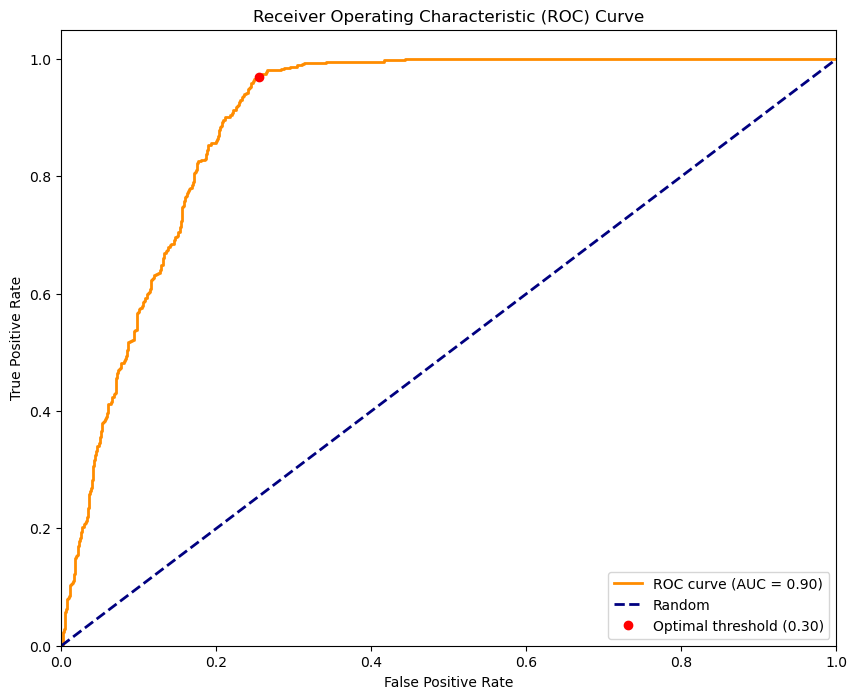

In [384]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add a point for the optimal threshold
optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold))
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', label=f'Optimal threshold ({optimal_threshold:.2f})')
plt.legend(loc="lower right")

plt.show()